## Objetivos del estudio

Demostrar si para el **grupo B** existe un **aumento del 10%** en la tasa de conversión para cada etapa del embudo.

In [2]:
# IMPORTACIÓN DE LIBRERIAS
import pandas as pd
from scipy import stats as st
import math  as mt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta as td

In [3]:
# ESTANDARIZAR NOMBRES DE COLUMNAS
def clean_colnames(df):
    df.columns = df.columns.str.lower().str.replace(' ','_')
    return df
# CONVERTIR FECHAS AL TIPO ADECUADO
def convert_dtypes(df, col, format):
    df[col] = pd.to_datetime(df[col], format = format)
    return df

# LECTURA DE DATOS, ESTANDARIZACIÓN DE LOS NOMBRE DE COLUMNAS, CONVERSIÓN A "DATETIME" 
# Y ELIMINACIÓN DE DUPLICADOS
mkt_events =  pd.read_csv('data/ab_project_marketing_events_us.csv')
mkt_events = clean_colnames(mkt_events).drop_duplicates()
mkt_events = convert_dtypes(mkt_events, "start_dt", '%Y-%m-%d')
mkt_events = convert_dtypes(mkt_events, "finish_dt", '%Y-%m-%d')

new_users = pd.read_csv('data/final_ab_new_users_upd_us.csv')
new_users = clean_colnames(new_users).drop_duplicates()
new_users = convert_dtypes(new_users, "first_date", '%Y-%m-%d')

new_users_events = pd.read_csv('data/final_ab_events_upd_us.csv')
new_users_events = clean_colnames(new_users_events).drop_duplicates()
new_users_events = convert_dtypes(new_users_events, "event_dt", '%Y-%m-%d %H:%M:%S')

participants = pd.read_csv('data/final_ab_participants_upd_us.csv')
participants = clean_colnames(participants).drop_duplicates()

In [4]:
display(mkt_events.sample(2))
display(new_users.sample(2))
display(new_users_events.sample(2))
display(participants.sample(2))
print(mkt_events.info())
print(new_users.info())
print(new_users_events.info())
print(participants.info())

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19


,user_id,first_date,region,device
22704,1F90097E49423D2C,2020-12-15,EU,PC
4520,57A7BCBA40E29D3F,2020-12-07,EU,PC


,user_id,event_dt,event_name,details
240376,3A8BE9CD53504801,2020-12-29 05:43:54,product_page,NaN
78757,E9FA498C886D78C6,2020-12-15 01:45:42,product_cart,NaN


,user_id,group,ab_test
1882,FFF28D02B1EACBE1,B,recommender_system_test
9048,E880347693DAAD38,B,interface_eu_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data colu

Las especificaciones de la prueba indican que el público de la prueba es de la **UE**, el **grupo control A** está sometido a ``interface_eu_test``, el **grupo experimental B** está sometido a ``recommender_system_test``. Se espera un aproximado de **6,000 participantes** de los cuales un **15%** pertenece al **grupo B**.

Dichas especificaciones se utilizarán para filtrar y separar los grupos de prueba.

In [ ]:
# FILTRADO DE EVENTOS DE MKT PARA LA UE
regions = ['EU, N.America','EU, CIS, APAC, N.America','EU, CIS, APAC']
mkt_events_eu = mkt_events.query("regions in @regions")

# FUSIÓN DE LOS DF "participants" y "new_users"
participants_merge = participants.merge(new_users,on="user_id")
#display(participants_merge.sample(2))

# FILTRADO DE PARTICIPANTES DE LA UE EN LA PRUEBA "recommender_system_test"
participants_eu = participants_merge.query("region == 'EU' and ab_test == 'recommender_system_test'")
participants_eu_id = participants_eu['user_id'] # ID DE LOS USUARIOS EN LA PRUEBA

# FILTRADO DE EVENTOS PARA LOS PARTICIPANTES DE LA PRUEBA DE EU
new_users_events_eu = new_users_events.query("user_id in @participants_eu_id") # EVENTOS DE USUARIOS EN LA PRUEBA

# BUSQUEDA DE USUARIOS DUPLICADOS EN "new_users_eu" y "participants_eu"
part_dupe = participants_eu.duplicated(subset=['user_id'])
print(f"Usuarios duplicados en 'participants_eu': {part_dupe.sum()}\n")

events_A = new_users_events_eu[['user_id','event_name']].merge(participants_eu.query("group == 'A'")[['user_id','group','ab_test']], on='user_id')
events_B = new_users_events_eu[['user_id','event_name']].merge(participants_eu.query("group == 'B'")[['user_id','group','ab_test']], on='user_id')
set_A = set(events_A['user_id'].unique())
set_B = set(events_B['user_id'].unique())
print(f"Participantes presentes en ambas muestras: {len(set_A & set_B)}")

Usuarios duplicados en 'participants_eu': 0

Participantes presentes en ambas muestras: 0


### Estudio del embudo de eventos

In [26]:
# FUSIÓN DE LOS DATA FRAMES 'new_users_events_eu' y 'participants_eu'
general = new_users_events_eu.merge(participants_eu.drop('ab_test',axis=1), on='user_id', how='inner')
general['date'] = general['event_dt'].dt.date

event_users_count = general.groupby(['event_name','group']).agg({'user_id':'count'})
event_users_count.columns = ['n_users']
event_users_count = event_users_count.sort_values(['group','n_users'], ascending=False).reset_index()
# REORDENACIÓN DEL DF PARA VISUALIZAR EL EMBUDO DE CONVERSIÓN
order = pd.CategoricalDtype(['login','product_page','product_cart','purchase'], ordered=True)
event_users_count['event_name'] = event_users_count['event_name'].astype(order)
event_users_count = event_users_count.sort_values(['group','event_name'], ascending=True).reset_index(drop=True)
#display(event_users_count)

# EMBUDO DE CONVERSIÓN POR ETAPAS (TOTAL Y RELATIVO A CADA ETAPA)
total_prop = []
rel_prop = []
for i in range(0,(len(event_users_count))):
    if i == 0 or i == 4:
        rel_prop.append(1)
        total_prop.append(1)
    elif  i >0 and i<4 :
        total_prop.append(event_users_count.loc[i,'n_users']/event_users_count.loc[0,'n_users'])
        rel_prop.append(event_users_count.loc[i,'n_users']/event_users_count.loc[i-1,'n_users'])
    else:
        total_prop.append(event_users_count.loc[i,'n_users']/event_users_count.loc[4,'n_users'])
        rel_prop.append(event_users_count.loc[i,'n_users']/event_users_count.loc[i-1,'n_users'])
event_users_count['tot_convertion'] = total_prop
event_users_count['rel_convertion'] = rel_prop

print("Embudo de conversión")
display(event_users_count)

# EVENTOS EN EL GRUPO A
events_A = general.query("group == 'A'")
# EVENTOS EN EL GRUPO B
events_B = general.query("group == 'B'")
# NO. DE EVENTOS PROMEDIO POR USUARIO
n_events_p_user = [len(events_A)/events_A['user_id'].nunique(), len(events_B)/events_B['user_id'].nunique()]
print(f"Eventos por usuario en el grupo A: {n_events_p_user[0]}")
print(f"Eventos por usuario en el grupo B: {n_events_p_user[1]}\n")
#display(general.sample(1))
n_events_p_user_A = events_A.groupby("user_id").size()
n_events_p_user_B = events_B.groupby("user_id").size()

# TEST DE LEVENE PARA COMPARAR LA VARIANZA DEL NÚMERO DE EVENTOS POR USUARIO EN AMBOS GRUPOS
alpha = 0.05
print(f"Nivel de significancia: {alpha}\n")

stat, p_value = st.levene(n_events_p_user_A, n_events_p_user_B)

print("Prueba de Levene para igualdad de varianzas entre tiempo de espera de llamadas internas y externas:\n")

print(f"Estadístico de prueba: {stat}")
print(f"Valor-p: {p_value}\n")

if p_value < alpha:
    print("Las varianzas son significativamente diferentes.")
else:
    print("No hay evidencia suficiente para decir que las varianzas son diferentes.")

print("\n")
# PRUEBA DE HIPÓTESIS PARA COMPARAR EL NÚMERO DE EVENTOS POR USUARIO EN AMBOS GRUPOS
results = st.ttest_ind(n_events_p_user_A, n_events_p_user_B, equal_var = True)
print("Prueba de hipótesis para el número de eventos por usuario en ambos grupos")
print("Estadístico de prueba:", results.statistic)
print("p-valor:", results.pvalue)
if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula: Hay diferencias significativas en el número de eventos por usuario entre ambos grupos.\n")
else:
    print("No rechazamos la hipótesis nula: No hay diferencias significativas en el número de eventos por usuario entre ambos grupos.\n")

Embudo de conversión


,event_name,group,n_users,tot_convertion,rel_convertion
0,login,A,7846,1.000000,1.000000
1,product_page,A,5043,0.642748,0.642748
2,product_cart,A,2351,0.299643,0.466191
3,purchase,A,2430,0.309712,1.033603
4,login,B,2415,1.000000,1.000000
5,product_page,B,1297,0.537060,0.537060
6,product_cart,B,643,0.266253,0.495759
7,purchase,B,649,0.268737,1.009331


Eventos por usuario en el grupo A: 6.785714285714286
Eventos por usuario en el grupo B: 5.70581527936146

Nivel de significancia: 0.05

Prueba de Levene para igualdad de varianzas entre tiempo de espera de llamadas internas y externas:

Estadístico de prueba: 3.3585138464093327
Valor-p: 0.0669438005383662

No hay evidencia suficiente para decir que las varianzas son diferentes.


Prueba de hipótesis para el número de eventos por usuario en ambos grupos
Estadístico de prueba: 7.546099515803743
p-valor: 5.693151204150573e-14
Rechazamos la hipótesis nula: Hay diferencias significativas en el número de eventos por usuario entre ambos grupos.



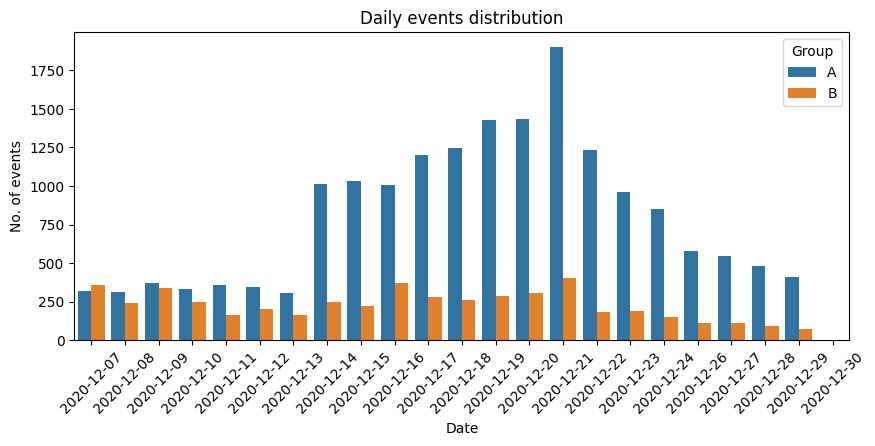

In [30]:
# DISTRIBUCIÓN DE EVENTOS POR DÍA Y POR GRUPO
daily_events = general.groupby(['date','group'])['event_name'].count().reset_index().sort_values(['date'])
daily_events.rename(columns={'event_name':'n_events'}, inplace=True) 
#display(daily_events.sample(3))
# DISTRIBUCIÓN DIARIA DE EVENTOS
plt.figure(figsize=(10,4))
sns.barplot(x="date", y="n_events", data=daily_events, hue = 'group', errorbar=None)
plt.title("Daily events distribution")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("No. of events")
plt.legend(title="Group")
plt.show()
#display(mkt_events_eu.query(" start_dt >= '2020-12-13' and finish_dt >= '2020-12-23'"))

<div class="alert alert-block alert-success">
<b>Acierto o fortaleza</b> <a class="tocSkip"></a><br>
El gráfico diario de la celda [9] segmentando por grupo es una buena forma de detectar anomalías temporales, como el pico entre 13–23 de diciembre. Es valioso porque orienta hipótesis sobre factores externos o efectos del experimento. Como ajuste menor, asegurarte de que <code>date</code> esté ordenado cronológicamente antes de graficar ayuda a la lectura (<code>daily_events.sort_values('date')</code>), y usar <code>ci=None</code> en <code>sns.barplot</code> evita barras de error no necesarias en conteos totales.
</div>

El EDA revela que:

- La cantidad de eventos de la etapa `product_cart` es menor a `purchase` para ambos grupos
- La cantidad de eventos por usuario para el grupo A es de 6.78, mientras que para el grupo B es de 5.70, la prueba de hipótesis para la igualdad de medias indica que existe una diferencia significativa entre la cantidad de eventos por usuario.
- Entre el *13-12-2020* y el *23-12-2020* la cantidad de eventos para el grupo A incrementó de manera considerable. Sin embargo, ningún evento de marketing está relacionado con estas fechas en particular (salvo el evento navideño (*2020-12-25/2021-01-03*)), por lo que se asume que este incremento no es debido a eventos promocionales.
- Ningún usuario está presente en ambas muestras.

### Resultados de la prueba A/B

Sean $H_0:\,p_\text{B}- p_\text{A}<= 0.1$ y $H_1:\,p_\text{B}- p_\text{A}>0.1$ las hipótesis nula y alternativa. Donde $p_\text{A}$ y $p_\text{B}$ son las tasas de conversión de los grupos A y B para los eventos: `product_page`, `product_cart` y `purchase`. Se elige una significancia $\alpha=0.05$.

In [ ]:
def z_test_proportions(df_A, df_B, alpha, event):
    # Calcular usuarios únicos que realizaron el evento
    users_A_event = df_A.query("event_name == @event")['user_id'].nunique()
    users_B_event = df_B.query("event_name == @event")['user_id'].nunique()
    
    # Total de usuarios únicos en cada grupo
    total_users_A = df_A['user_id'].nunique()
    total_users_B = df_B['user_id'].nunique()
    
    # Calcular proporciones
    p1 = users_A_event / total_users_A  # Proporción grupo A
    p2 = users_B_event / total_users_B  # Proporción grupo B
    
    # Diferencia de proporciones ajustada
    difference = p2-p1-0.1
    
    # Calcular el estadístico z y el valor p
    z_value = difference / mt.sqrt(p1*(1 - p1)/total_users_A +p2*(1 - p2)/total_users_B)
    p_value = (1 - st.norm.cdf(z_value))
    
    # Imprimir resultados
    print(f"Prueba Z para el evento '{event}'")
    print(f"Estadístico de prueba (z): {z_value}")
    print(f"Valor-p: {p_value}")
    if (p_value < alpha) and (p2>p1) :
        print("Rechazar la hipótesis nula\n")
    else:
        print("No se pudo rechazar la hipótesis nula\n")


z_test_proportions(df_A=events_A, df_B= events_B, alpha=0.05, event = 'product_page')
z_test_proportions(df_A=events_A, df_B= events_B, alpha=0.05, event = 'product_cart')
z_test_proportions(df_A=events_A, df_B= events_B, alpha=0.05, event = 'purchase')

Prueba Z para el evento 'product_page'
Estadístico de prueba (z): -9.63586275744201
Valor-p: 1.0
No se pudo rechazar la hipótesis nula

Prueba Z para el evento 'product_cart'
Estadístico de prueba (z): -6.937703662718877
Valor-p: 0.9999999999980074
No se pudo rechazar la hipótesis nula

Prueba Z para el evento 'purchase'
Estadístico de prueba (z): -7.6565000893513675
Valor-p: 0.9999999999999905
No se pudo rechazar la hipótesis nula



# Informe de conclusiones y recomendaciones: Prueba A/B

Tras el análisis estadístico y la revisión de la calidad de los datos, se presentan las siguientes conclusiones y recomendaciones estratégicas:

## 1. Evaluación de resultados estadísticos
Los análisis realizados no lograron validar la hipótesis principal. No se observó el aumento esperado del **10%** en las tasas de conversión para el **grupo B** en ninguno de los eventos del embudo. Por el contrario, los datos sugieren que el nuevo sistema de recomendaciones no generó el impacto positivo proyectado.

## 2. Integridad de los datos
Se han detectado inconsistencias críticas en la recolección de datos que podrían comprometer la fiabilidad del análisis. Específicamente, la tasa de conversión entre las etapas `product_cart` y `purchase` supera el **100%**, lo cual es técnicamente imposible e indica un fallo en el registro de los eventos.

## 3. Anomalías temporales
Se recomienda realizar una investigación profunda sobre los factores externos que pudieron influir en el tráfico durante el periodo del **13 al 23 de diciembre de 2020**. Se detectó un aumento anómalo en el volumen de eventos durante estas fechas que requiere justificación (ej. campañas de marketing estacionales o errores técnicos).

## 4. Recomendación final
Basado estrictamente en la evidencia cuantitativa recabada y considerando las inconsistencias en los datos, **no se recomienda la implementación del sistema de recomendaciones** en este momento. El sistema no solo falló en alcanzar el objetivo de mejora, sino que mostró indicios de ser contraproducente para la conversión de usuarios.